## Gaussian Process Regression example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

First we'll read in the data and take a quick look at some of the data points.

In [2]:
# Read in the data
df_gp = pd.read_csv('../Data/gp_data.csv')

In [3]:
# Look at the data
df_gp.head(5)

,x,y
0,-3.213717,15.410904
1,-2.583426,22.534045
2,-2.147617,4.547179
3,-1.634624,9.537378
4,-1.506149,8.213919


Next we'll create a scatter plot of the data.

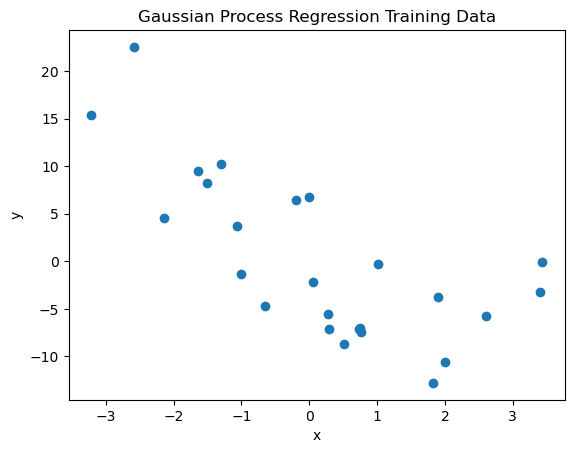

In [4]:
# Plot the training data
plt.scatter(df_gp['x'], df_gp['y'])
plt.title('Gaussian Process Regression Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The scatter plot suggests possibly a quadratic relationship between $x$ and $y$ over longer lengthscales, but there could be some more fine grained variation. We'll use a Gaussian Process to estimate the mean (expected) relationship between $y$ and $x$ in this training data set.

We will use an RBF kernel, i.e. we choose our function $K$ to be $K(x_{i}, x_{j}) = A\exp \left ( -\frac{\left (x_{i} - x_{j} \right )^{2}}{2b^{2}} \right )$. We can do this using the RBF constructor from the sklearn.gaussian_process.kernels module. We'll set the value of $b=1$ but sklearn will optimize this value for us. The value $b=1$ is just an initial guess. We specify the RBF kernel using the syntax 1\*RBF(length_scale=1.0). The prefactor of 1 infront of the RBF constructor call introduces an extra parameter into our RBF kernel, in this case it is the parameter $A$, and we have initialized its value to 1. Again sklearn will optimize this parameter for us by fitting to the data.

We must also add a noise component to our kernel. This is the $\sigma^{2}\underline{\underline{I}}_{N}$ part of the overall covariance matrix. We do this by adding a sklearn WhiteKernel object to our RBF kernel. Again, sklearn will optimize the noise level parameter $\sigma^{2}$ when it fits to the data.    

In [5]:
# Specify our kernel
kernel = 1*RBF(length_scale=1.0) + WhiteKernel(noise_level_bounds=(1.0, 20.0))

So now we have our kernel, we can create a Gaussian Process Regression object by calling the sklearn GaussianProcessRegressor constructor, passing in the kernel object we already created.

In [6]:
# Create GaussianProcessRegressor object which we will use to do our Gaussian Process Regression 
gaussian_process = GaussianProcessRegressor(kernel=kernel)

Now we can optimize the parameters $A, b, \sigma$ by calling the fit method of the GaussianProcessRegressor object, into which we pass our training data

In [7]:
# Optimize the model parameters
gaussian_process.fit(df_gp['x'].values.reshape(-1,1), df_gp['y'])

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))

Let's take a look at the optimized parameters. We can do this by just looking at the kernel object

In [8]:
# Look at the kernel object after we have optimized it
gaussian_process.kernel_

9.24**2 * RBF(length_scale=0.412) + WhiteKernel(noise_level=8.33)

We can see the optimized kernel is of the form $K\left (x_{i},x_{j}\right ) = 9.24^{2} \times \exp\left (-\frac{\left ( x_{i} - x_{j}\right )^{2}}{2\times0.412^{2}}\right ) + 8.33\times \delta_{ij}$. This means sklearn has chosen the optimal values as $A=9.24^{2}$, $b=0.412$ and $\sigma^{2}=8.33$.

Having got our optimal GaussianProcessRegressor, let's use it to make some prediction. We make predictions for regularly spaced values of $x$ between the maximum and minimum values of $x$ seen in the training data set. The predictions are the expectation values of the response (target) variable at each of the prediction points. We'll also get the standard deviations of the response variable so we can plot confidence intervals around our predictions.

In [9]:
# Create a range of x values for prediction
x_predict = np.arange(df_gp['x'].min(), df_gp['x'].max(), 0.01).reshape(-1,1)

# Get the prediction (expectation) and standard deviation.
mean_prediction, std_prediction = gaussian_process.predict(x_predict, return_std=True)

We'll also calculate the true expectation values of the response variable at each of the prediction points. I can do this because I know the formula used to create the true expectation values of the response variable in training data.

In [10]:
# Calculate true expectation value
y_true = [(-3.4 - 2.0*x + (x-1.0)**2 + 5.5*np.sin(5.0*x-4.0))[0] for x in x_predict]

Finally we plot the predictions (estimates of the expectation values), the 95% confidence intervals and the true expectation values, and the training data points.

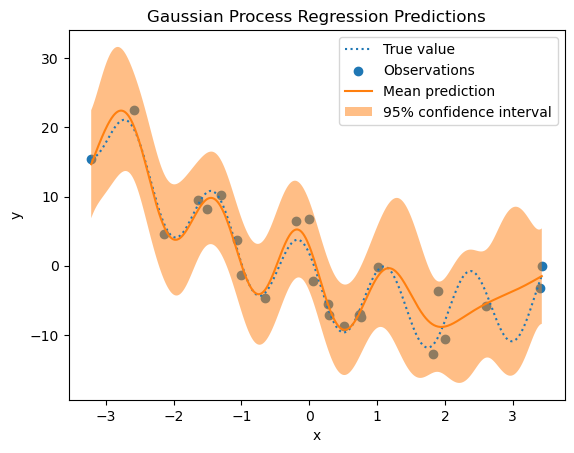

In [11]:
# Plot the predictions
plt.plot(x_predict, y_true, label="True value", linestyle="dotted")
plt.scatter(df_gp['x'], df_gp['y'], label="Observations")
plt.plot(x_predict, mean_prediction, label="Mean prediction")
plt.fill_between(
    x_predict.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.title('Gaussian Process Regression Predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()